# Qiskit Aer: Device noise model simulations

* *Author*: Christopher J. Wood (cjwood@us.ibm.com)
* *Last updated*: December 10, 2018

This notebook demonstrates how to use the built in device noise models from Qiskit Aer to run simulations that approximate errors on a real device.

In [1]:
import numpy as np
import time

# Import Terra
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.tools._monitor import job_monitor

# Import IBMQ provider
from qiskit import IBMQ
# Import Aer backends
from qiskit_aer import Aer
from qiskit_aer.noise.device import depolarizing_noise_model
from qiskit_aer.noise.device import thermal_relaxation_noise_model

# Load IBMQ accounts to access online backends
IBMQ.load_accounts()
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx5') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

## IBMQ Device

We will choose an IBMQ device to simulator and get its *properties* which will be used to automatically generate a simple noise model, and its *coupling map* which will be used to compile qobj to supported circuit for the simulators.

In [2]:
device = IBMQ.get_backend('ibmq_16_melbourne')
properties = device.properties()
coupling_map = device.configuration().coupling_map

## Test circuit and ideal output

We make two test circuits preparing an entangled Bell-state: one using the device supported CNOT, and the other the reverse direction CNOT

Aer QasmSimulator: Ideal output


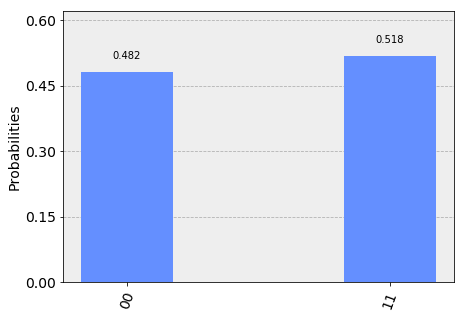

In [3]:
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')

# Prepare a bell state
circ = QuantumCircuit(qr, cr, name='bell')
circ.h(qr[1])
circ.cx(qr[1], qr[0])
circ.measure(qr, cr)

# Ideal execution
simulator = Aer.get_backend('qasm_simulator')
job_ideal = qiskit.execute(circ, simulator, shots=1000,
                     coupling_map=coupling_map)
result_ideal = job_ideal.result()
counts_ideal = result_ideal.get_counts(circ)
print("Aer QasmSimulator: Ideal output")
plot_histogram(counts_ideal)

## Simulate using Aer device noise model

### Depolarizing noise model simulation

Aer QasmSimulator: with depol noise model
Bell-State counts


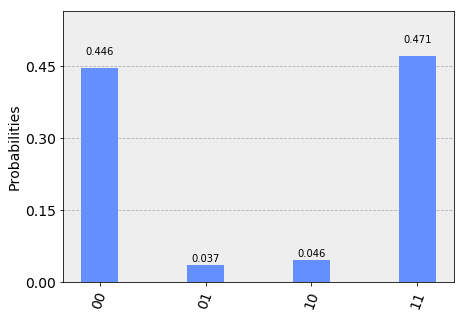

In [4]:
noise_depol = depolarizing_noise_model(properties)
basis_gates = noise_depol.basis_gates
simulator = Aer.get_backend('qasm_simulator')
job_depol = qiskit.execute(circ, simulator, shots=1000,
                     coupling_map=coupling_map,
                     basis_gates=basis_gates,
                     noise_model=noise_depol)
result_depol = job_depol.result()
counts_depol = result_depol.get_counts(0)
print("Aer QasmSimulator: with depol noise model")
print("Bell-State counts")
plot_histogram(counts_depol)

### Thermal relaxation noise model simulation

Aer QasmSimulator: with relaxation noise model
Bell-State counts


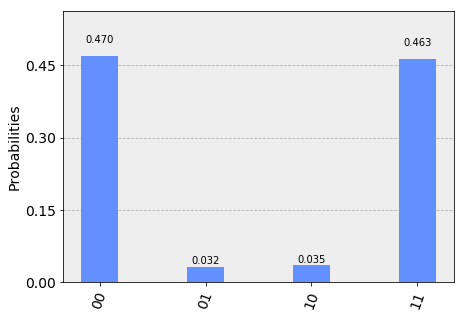

In [5]:
noise_relax = thermal_relaxation_noise_model(properties)
basis_gates = noise_relax.basis_gates
job_relax = qiskit.execute(circ, simulator, shots=1000,
                     coupling_map=coupling_map,
                     basis_gates=basis_gates,
                     noise_model=noise_relax)
result_relax = job_relax.result()
counts_relax = result_relax.get_counts(0)
print("Aer QasmSimulator: with relaxation noise model")
print("Bell-State counts")
plot_histogram(counts_relax)

## Results from execution on IBMQ device

In [6]:
# Submit job to device
job_ibmq = qiskit.execute(circ, device, shots=1000)

In [7]:
job_monitor(job_ibmq)

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

IBMQ device: ibmq_16_melbourne
Bell-State counts


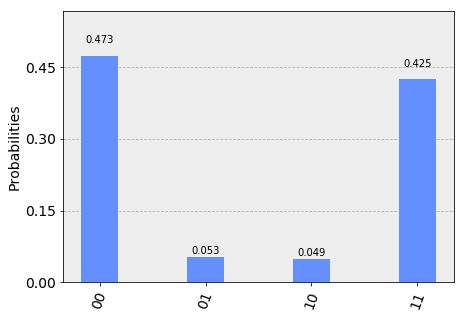

In [8]:
# Get results from completed execution
result_ibmq = job_ibmq.result()
counts_ibmq = result_ibmq.get_counts(0)
print("IBMQ device: {}".format(device.name()))
print("Bell-State counts")
plot_histogram(counts_ibmq)